In [1]:
import numpy as np
import math
import pandas as pd
import cv2
import os
#import tqdm
#from scipy.io import loadmat

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from PIL import Image
# import pytesseract

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K

# from utils import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.layers import *

# from keras.applications import MobileNetV2
# from keras.applications import InceptionResNetV2

from keras.models import Model
from keras.models import model_from_json
from keras import regularizers

#from keras.initializers import he_normal


In [2]:
target_size = [608, 608]
target_w = 608 # target sizes of image in model input
target_h = 608 #target sizes of image in model input

class_num = 1     ## item

categories = ['bom'] # details of classes

In [18]:
num_image_folder = []
drg_image = []

for i in range(1, 28):
    drg_folder = 'drg_test_' + str(i)
    drg_directory = '/Users/subrata/workstation/jupyterFiles/yolo_data_file/' + drg_folder
    inter_var_1 = drg_directory + '/{}'
    drg_folder = [inter_var_1.format(i) for i in os.listdir(drg_directory)]
    num_image_folder.append(len(drg_folder))
    drg_image.append(drg_folder)

print('Number of images in folders = ', num_image_folder)

num_images = len(drg_image)

print('Number of image folders = ', num_images)


Number of images in folders =  [36, 36, 36, 42, 36, 41, 35, 54, 54, 40, 106, 54, 61, 53, 98, 97, 95, 99, 12, 32, 45, 45, 45, 47, 46, 66, 58]
Number of image folders =  27


In [19]:
## drg_image above is a list of lists. We need to flatten this : 

from itertools import chain

k = list(chain.from_iterable(map(list, drg_image)))
drg_image = k
drg_image.sort() # Sorting the list

print(len(drg_image))

1469


In [43]:
# Check sizes of exiting images & Create a Dataframe with image id and height(row) and width(column):

rows = []
columns = []
image_sl = []
df_image_size = pd.DataFrame()

for i in range(len(drg_image)):
    image = cv2.imread(drg_image[i]) ## Loading image
    
    
    height, width, _ = image.shape
    rows.append(height)
    columns.append(width)
    image_sl.append(drg_image[i])
print(len(rows))      
row_values = pd.Series(rows)
col_values = pd.Series(columns)
image_num = pd.Series(image_sl)


df_image_size.insert(loc=0, column='image_serial', value=image_num)
df_image_size.insert(loc=1, column='rows', value=row_values)
df_image_size.insert(loc=2, column='columns', value=col_values)

df_image_size.tail(3)

1469


,image_serial,rows,columns
1466,/Users/subrata/workstation/jupyterFiles/yolo_d...,1240,1754
1467,/Users/subrata/workstation/jupyterFiles/yolo_d...,1240,1754
1468,/Users/subrata/workstation/jupyterFiles/yolo_d...,1240,1754


In [44]:
# Loading output of VGG Image Annotation tool and create a dataframe

region_data = []

for i in range(1, 28):
    via_folder = '/Users/subrata/workstation/jupyterFiles/yolo_data_file/via_region_data_drg_test_' + str(i) + '.csv'
    region = pd.read_csv(via_folder)
    region_data.append(region)
    
r_data = pd.concat(region_data)

# Create data_master having bbox information :

r_data_master = r_data[~r_data['region_shape_attributes'].str.contains('{}')].reset_index(drop=True)
r_data_master_unique = r_data_master.drop_duplicates('#filename', keep=False).reset_index(drop=True)
r_data_master_unique.drop(r_data_master_unique.columns[[1, 2, 3, 4]], axis=1, inplace=True) # reduce unnecessary columns
num_images_in_data_master = r_data_master_unique["#filename"].nunique()
r_data_master_image_list = r_data_master_unique["#filename"].tolist()


# Create drg master having bbox information :

reqd_drg_image = []
k = 0

for i in r_data_master_image_list:

    # print(i)
    image_desc = [s for s in drg_image if i in s]
    # print(image_desc)

    if image_desc != []:
        reqd_drg_image.append(image_desc)

    if image_desc == []:
        r_data_master_unique = r_data_master_unique[r_data_master_unique['#filename'] != i]

 #   reqd_drg_image.append(image_desc)
 #   print(reqd_drg_image[k])
    # print('*************************')
 #   k=k+1

r_data_master_unique = r_data_master_unique.reset_index(drop = 'True')
print(len(r_data))         # all data including drgs with no bbox data
print(len(r_data_master))  # data with drgs having bbox information

print(len(r_data_master_unique))
print(len(r_data_master_image_list))

print(num_images_in_data_master)
print(len(drg_image))      # all drg images
print(len(reqd_drg_image)) # drgs having bbox information



1470
1461
1432
1435
1435
1469
1432


In [45]:
# Check sizes of exiting images & Create a Dataframe with image id and height(row) and width(column):

rows = []
columns = []
image_sl = []
df_image_size = pd.DataFrame()

for i in range(len(reqd_drg_image)):
 #   print(i)
    image = cv2.imread(reqd_drg_image[i][0]) ## Loading image
    
    height, width, _ = image.shape
    rows.append(height)
    columns.append(width)
    image_sl.append(reqd_drg_image[i][0])
print(len(rows))      
row_values = pd.Series(rows)
col_values = pd.Series(columns)
image_num = pd.Series(image_sl)


df_image_size.insert(loc=0, column='image_serial', value=image_num)
df_image_size.insert(loc=1, column='rows', value=row_values)
df_image_size.insert(loc=2, column='columns', value=col_values)

df_image_size.tail(3)

1432


,image_serial,rows,columns
1429,/Users/subrata/workstation/jupyterFiles/yolo_d...,2479,3508
1430,/Users/subrata/workstation/jupyterFiles/yolo_d...,2479,3508
1431,/Users/subrata/workstation/jupyterFiles/yolo_d...,2479,3508


In [47]:
i = 1050
r_attribs = r_data_master_unique.values[i, 2][1:(len(r_data_master_unique.values[i, 2])-1)]
print(r_attribs)
i = 1051
r_attribs = r_data_master_unique.values[i, 2][1:(len(r_data_master_unique.values[i, 2])-1)]
print(r_attribs)

"text":"bom"



In [49]:
i = 1420
r_attribs = r_data_master_unique.values[i, 2][1:(len(r_data_master_unique.values[i, 2])-1)]
print(r_attribs)

"bom":""


In [50]:
# Making a dataframe for Image_id, x, y, width, height, class, image_width and image_height

x = []  # co-ordinate of bbox left-top corner and NOT center of bbox
y = []  # co-ordinate of bbox left-top corner and NOT center of bbox
width = []
height = []
obj_class = []
i_width = []
i_height = []
img_path = []
img_index = []

for i in range(len(r_data_master_unique)):
    
    r_size = r_data_master_unique.values[i, 1][1:(len(r_data_master_unique.values[i, 1])-1)]
    r_size_par = r_size.split(",")
    
    # print(i)
    
    x.append(int("".join(filter(str.isdigit, r_size_par[1]))))
#    print('=================================================')
    y.append(int("".join(filter(str.isdigit, r_size_par[2]))))
    width.append(int("".join(filter(str.isdigit, r_size_par[3]))))
    height.append(int("".join(filter(str.isdigit, r_size_par[4]))))
    
    r_attribs = r_data_master_unique.values[i, 2][1:(len(r_data_master_unique.values[i, 2])-1)]
    if r_attribs == '':
        this_class = 0
    else:
        this_class = 1
    obj_class.append(this_class)
    
    foto_id = r_data_master_unique['#filename'][i]

    # print(foto_id)

    final_image_list = df_image_size['image_serial'].to_list()
    # flat_image_list = [item for sublist in final_image_list for item in sublist]
    # print(final_image_list[0])
    i_path = [s for s in final_image_list if foto_id in s]
    # foto_index = [idx for idx, s in enumerate(final_image_list[:][0]) if foto_id in s][0]
    foto_index = [idx for idx, s in enumerate(final_image_list) if foto_id in s][0]
    

    # print(i)
    # print(i_path)
    # print(type(i_path))
    # print(i_path[0])
    # print(len(i_path))
    # print(foto_index)


    # print('====================================')
    
    
    foto_width = df_image_size['columns'][foto_index]
    foto_height = df_image_size['rows'][foto_index]
    i_width.append(foto_width)
    i_height.append(foto_height)
    img_path.append(i_path)
    img_index.append(foto_index)
    
x_values = pd.Series(x)
y_values = pd.Series(y)
width_values = pd.Series(width)
height_values = pd.Series(height)
class_values = pd.Series(obj_class)
i_width_values = pd.Series(i_width)
i_height_values = pd.Series(i_height)
img_path_values = pd.Series(img_path)
img_index_values = pd.Series(img_index)

r_data_master_unique.insert(loc=1, column='img_idx', value=img_index_values)
r_data_master_unique.insert(loc=2, column='i_path', value=img_path_values)
r_data_master_unique.insert(loc=3, column='x', value=x_values)
r_data_master_unique.insert(loc=4, column='y', value=y_values)
r_data_master_unique.insert(loc=5, column='width', value=width_values)
r_data_master_unique.insert(loc=6, column='height', value=height_values)
r_data_master_unique.insert(loc=7, column='obj_class', value=class_values)
r_data_master_unique.insert(loc=8, column='img_wd', value=i_width_values)
r_data_master_unique.insert(loc=9, column='img_ht', value=i_height_values)

r_data_master_unique.drop(r_data_master_unique.columns[[10, 11]], axis=1, inplace=True) # reduce unnecessary columns

r_data_master_unique.rename({'#filename': 'img_id'}, axis=1, inplace=True) # changing column name

num_images = len(r_data_master_unique)
print(num_images)

r_data_master_unique.tail(3)


1432


,img_id,img_idx,i_path,x,y,width,height,obj_class,img_wd,img_ht
1429,SOM 14 003437 MHIL-Model-1-page-001.jpg,1429,[/Users/subrata/workstation/jupyterFiles/yolo_...,0,0,0,0,0,3508,2479
1430,SOM 14 003437 MHIL-Model-2-page-001.jpg,1430,[/Users/subrata/workstation/jupyterFiles/yolo_...,0,0,0,0,0,3508,2479
1431,SOM 14 003437 MHIL-Model-page-001.jpg,1431,[/Users/subrata/workstation/jupyterFiles/yolo_...,0,0,0,0,0,3508,2479


In [51]:
r_data_master_unique[1050:1053]

,img_id,img_idx,i_path,x,y,width,height,obj_class,img_wd,img_ht
1050,JW322-11@1000-02-00 RH-Model-page-001.jpg,1050,[/Users/subrata/workstation/jupyterFiles/yolo_...,2033,714,1276,1172,1,3508,2479
1051,3224-2011-01-C-Model-page-001.jpg,1051,[/Users/subrata/workstation/jupyterFiles/yolo_...,0,0,0,0,0,3508,2479
1052,3224-2011-01-F-Model-page-001.jpg,1052,[/Users/subrata/workstation/jupyterFiles/yolo_...,0,0,0,0,0,3508,2479


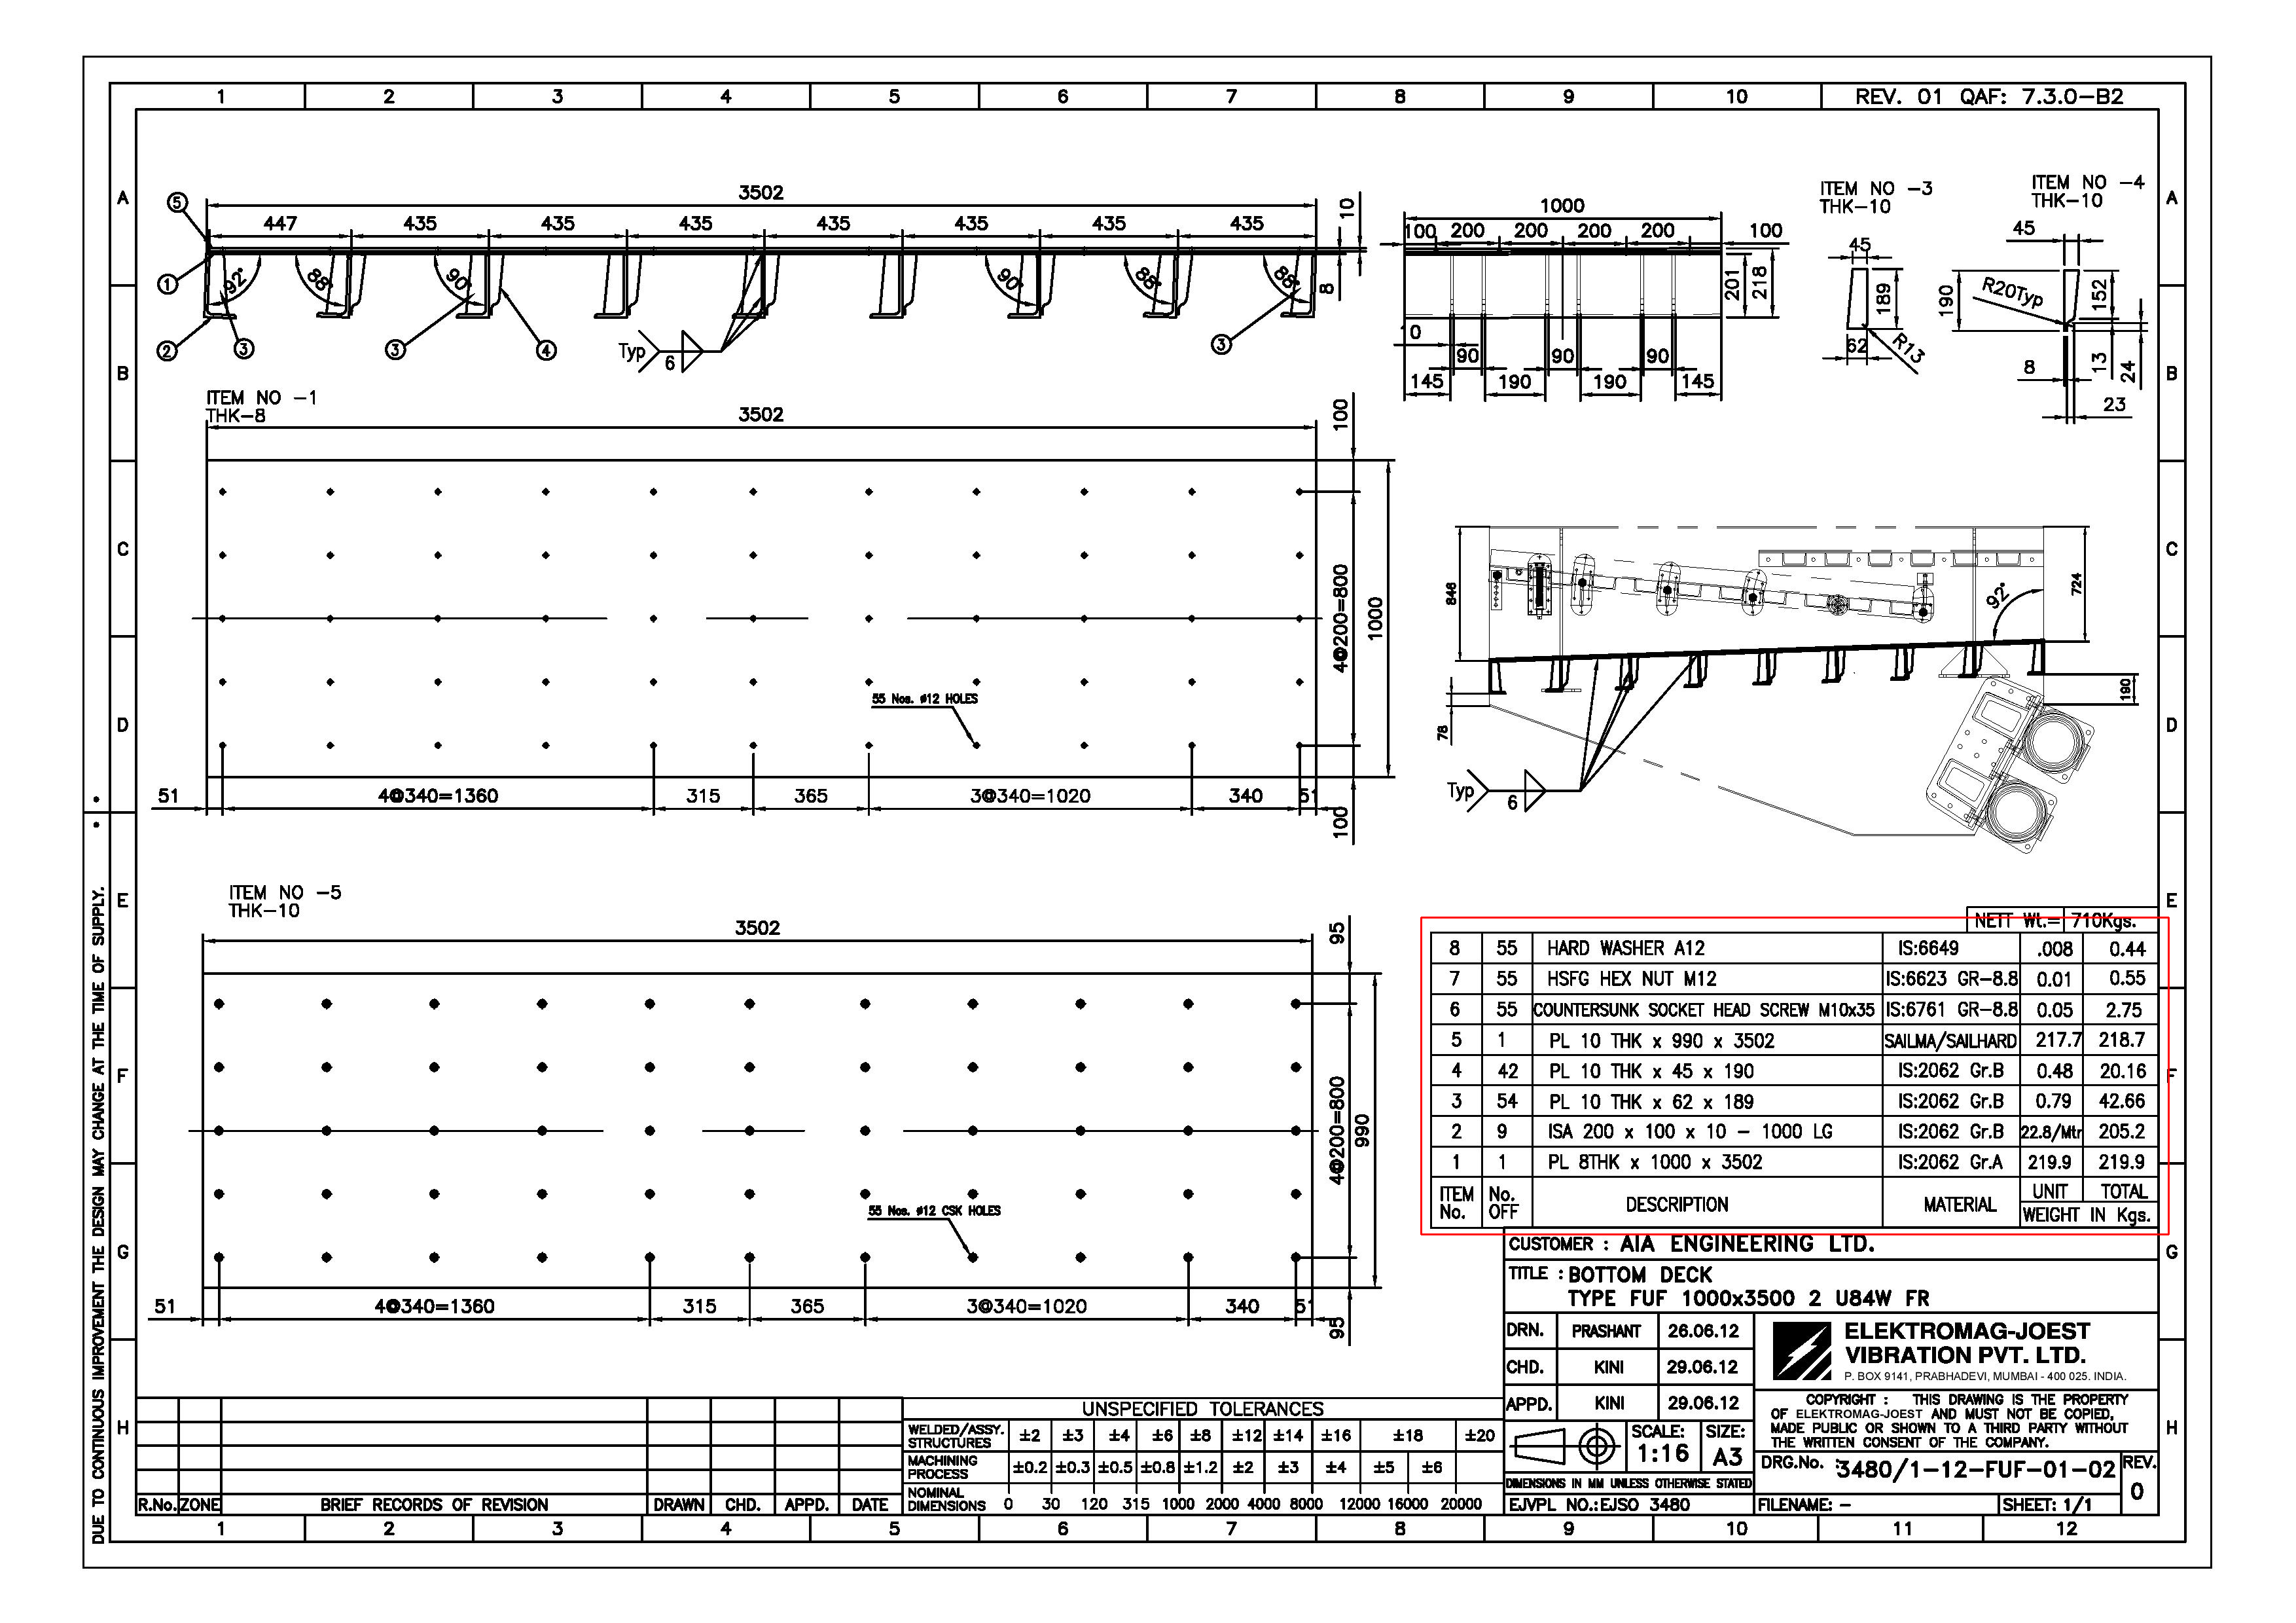

In [33]:
i = 1

x_path = r_data_master_unique['i_path'][i]
x = cv2.imread(x_path[0])

x_min = r_data_master_unique['x'][i]
x_max = r_data_master_unique['x'][i] + r_data_master_unique['width'][i]

y_min = r_data_master_unique['y'][i]
y_max = r_data_master_unique['y'][i] + r_data_master_unique['height'][i]

cv2.rectangle(x, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

x_pil = Image.fromarray(x)
display(x_pil)

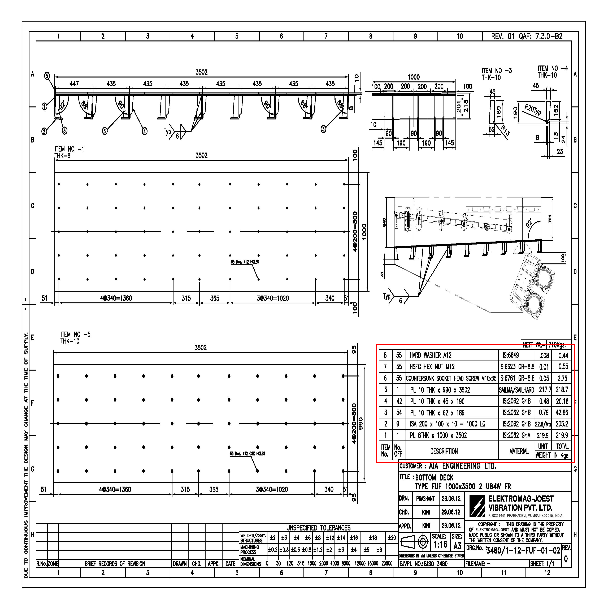

In [34]:
target_size = [608, 608]
target_w = 608 # target sizes of image in model input
target_h = 608 #target sizes of image in model input

i = 1

x_path = r_data_master_unique['i_path'][i]
x = cv2.imread(x_path[0])
x_resized = cv2.resize(x,(target_size[0], target_size[1]))

img_width = r_data_master_unique['img_wd'][i]
img_height = r_data_master_unique['img_ht'][i]

x_ratio = target_size[1] / img_width
y_ratio = target_size[0] / img_height

x_min_resized = round(r_data_master_unique['x'][i]*x_ratio)
x_max_resized = round(r_data_master_unique['x'][i]*x_ratio + r_data_master_unique['width'][i]*x_ratio)

y_min_resized = round(r_data_master_unique['y'][i] * y_ratio)
y_max_resized = round(r_data_master_unique['y'][i] * y_ratio + r_data_master_unique['height'][i] * y_ratio)

cv2.rectangle(x_resized, (x_min_resized, y_min_resized), (x_max_resized, y_max_resized), (255, 0, 0), 1)

x_pil = Image.fromarray(x_resized)
display(x_pil)

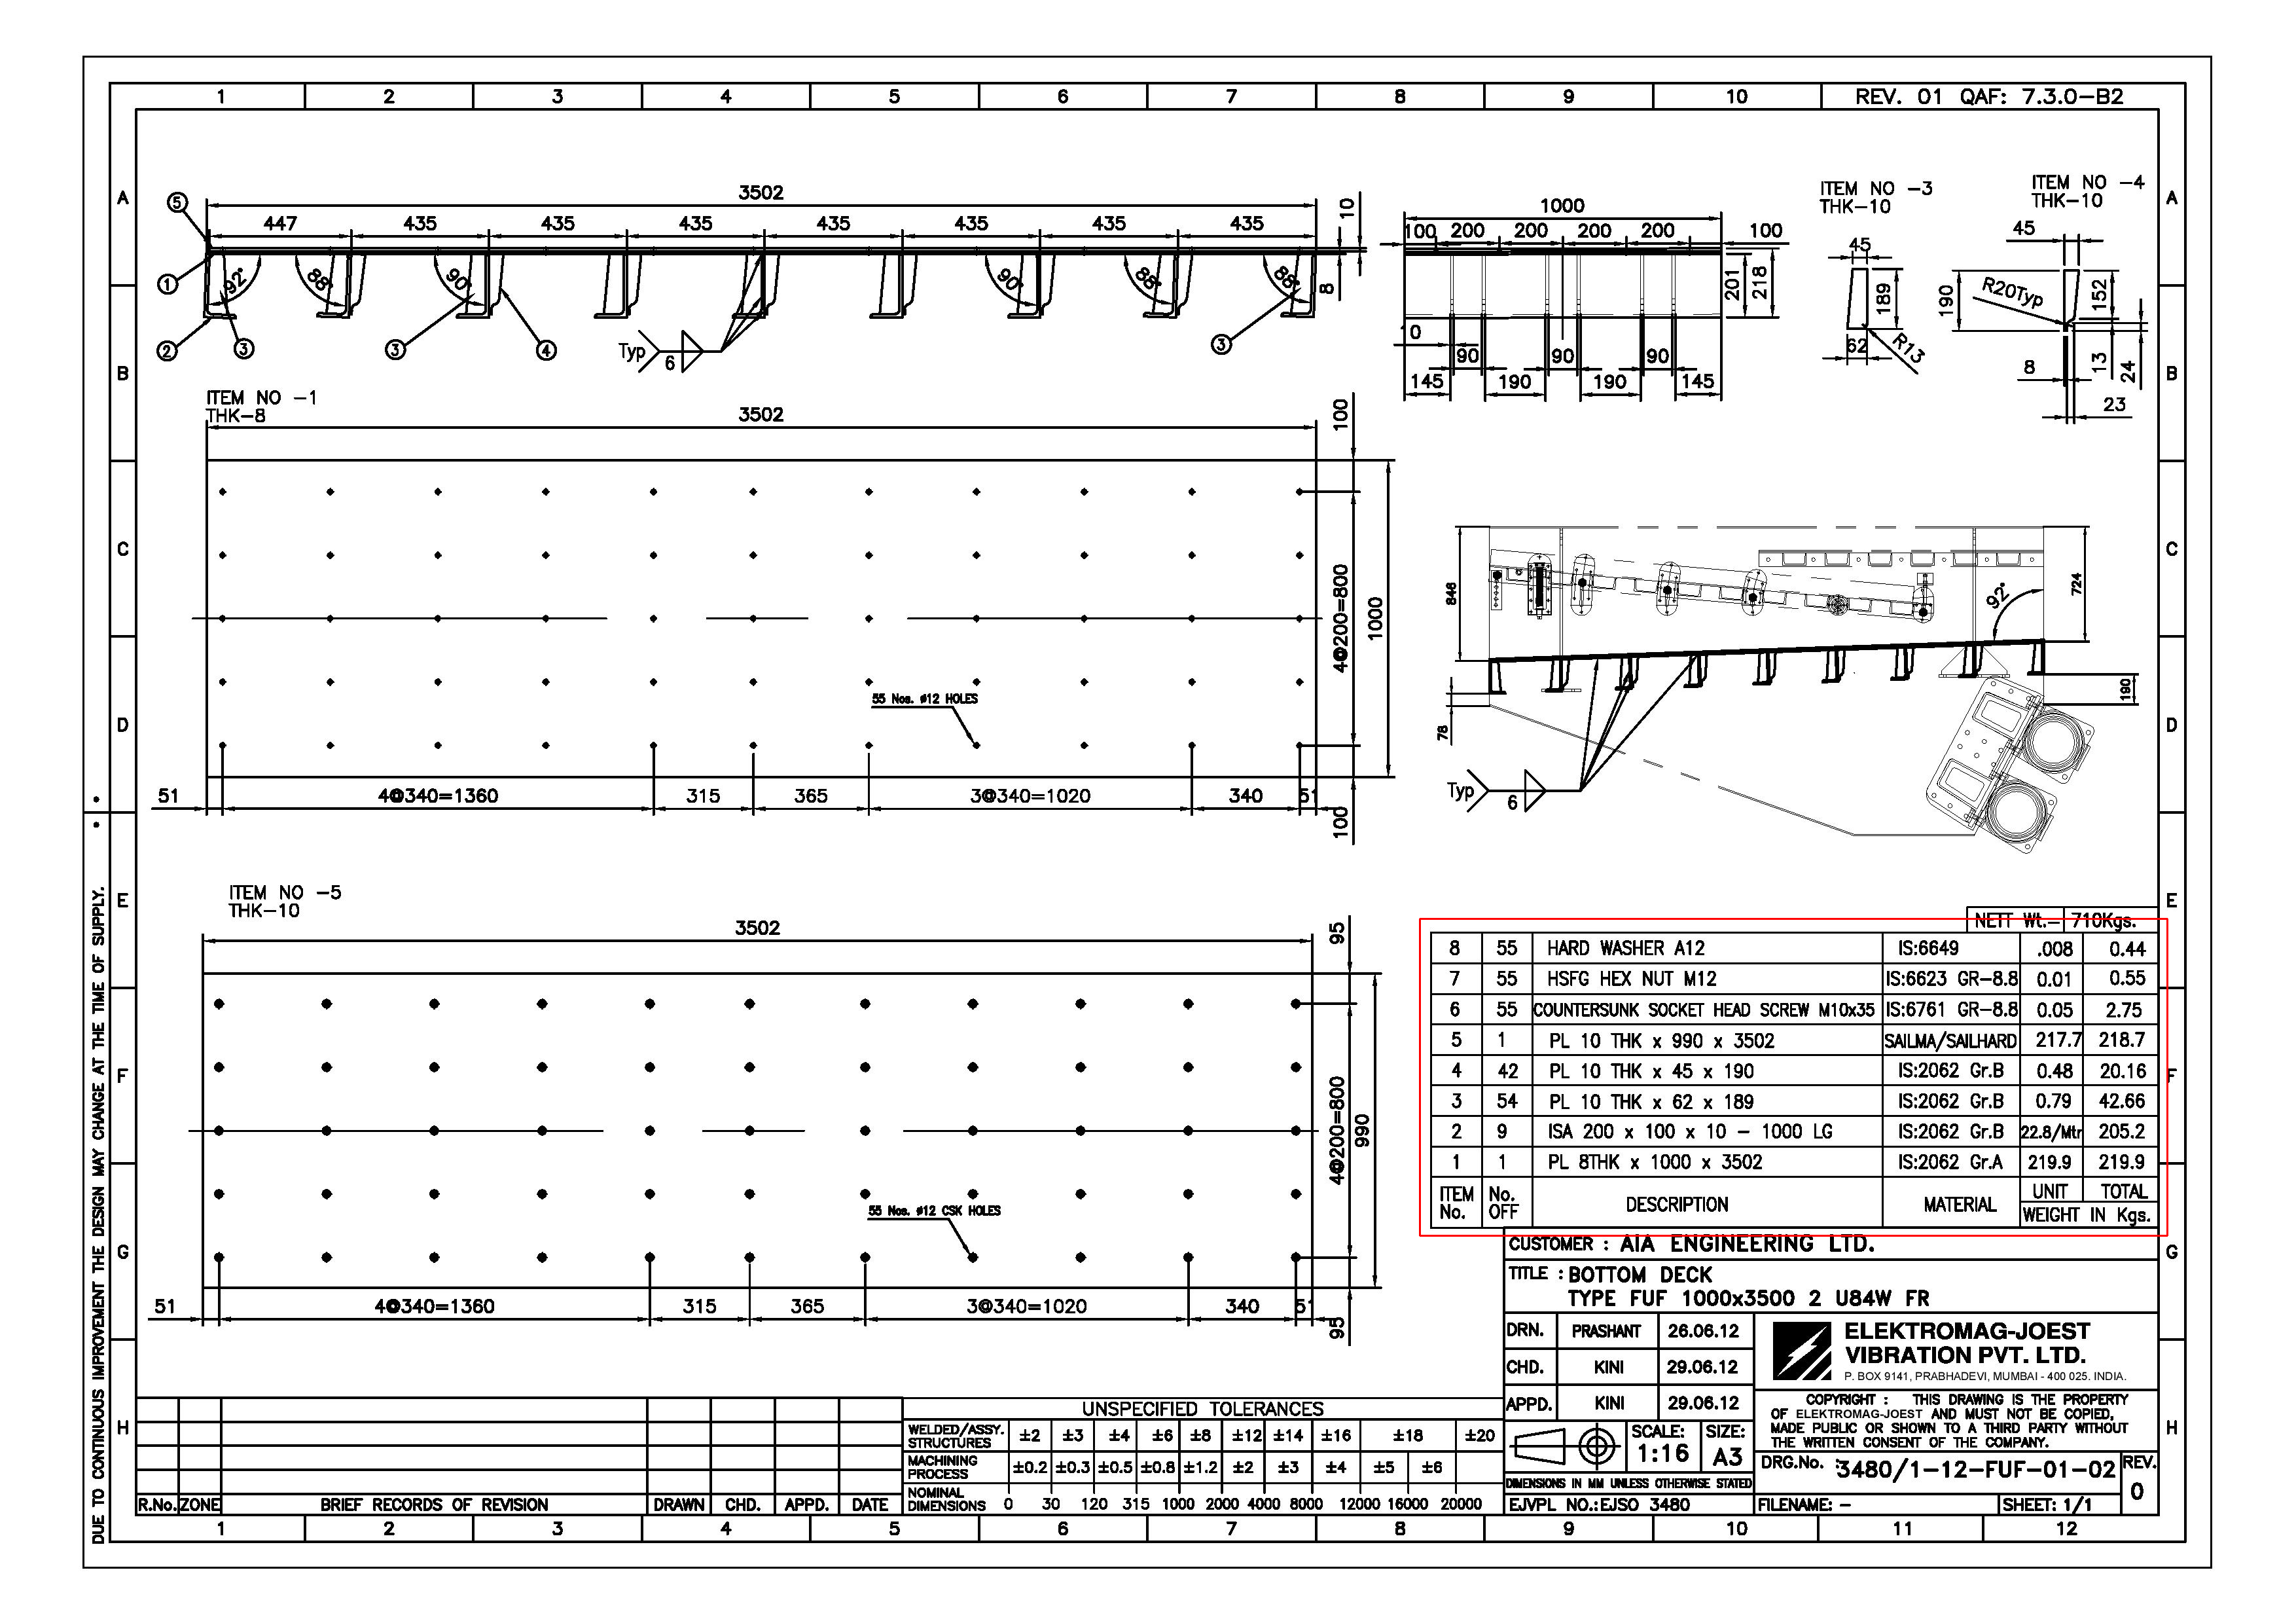

In [35]:
# x_min_resized = round(r_data_master_unique['x'][i]*x_ratio)
x_min = round(x_min_resized / x_ratio)
# x_max_resized = round(r_data_master_unique['x'][i]*x_ratio + r_data_master_unique['width'][i]*x_ratio)
x_max = x_min + r_data_master_unique['width'][i]

# y_min_resized = round(r_data_master_unique['y'][i] * y_ratio)
y_min = round(y_min_resized / y_ratio)
# y_max_resized = round(r_data_master_unique['y'][i] * y_ratio + r_data_master_unique['height'][i] * y_ratio)
y_max = y_min + r_data_master_unique['height'][i]

cv2.rectangle(x, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

x_pil = Image.fromarray(x)
display(x_pil)

In [38]:
def single_image_info(lines):
    
    ## lines will be a dataframe like, for i in range(num_images), lines = r_new_data[i*5:(i+1)*5]
    
    line_idx = lines.iat[0, 1]
    pic_path = lines.iat[0, 2]
    img_width = lines.iat[0, 8]
    img_height = lines.iat[0, 9]
    
    boxes = []
    labels = []
    for i in range(len(lines)):
        
        label = lines['obj_class'][i]
        x_min, y_min, x_max, y_max = float(lines.iat[i,3]), float(lines.iat[i,4]), float(lines.iat[i,3]+lines.iat[i,5]), float(lines.iat[i,4]+lines.iat[i,6])
        boxes.append([x_min, y_min, x_max, y_max])
        labels.append(label)
        
    boxes = np.asarray(boxes, np.float32)
    labels = np.asarray(labels, np.int64)
    
    return line_idx, pic_path, boxes, labels, img_width, img_height  ## boxes are in format xmin, ymin, xmax, ymax


In [52]:
## Creating the complete data set :

all_image_line = []
limit_lower = 0
limit_upper = 0

for i in range(num_images):

    image_line = []
    
    img = r_data_master_unique['img_id'][limit_upper]
    kount = r_data_master_unique['img_id'].value_counts()[img]      ## this gives no. of same images with region data of multiple categories
       
    limit_lower = limit_upper
    limit_upper = limit_lower + kount
    
    lines = r_data_master_unique[limit_lower:limit_upper].reset_index(drop=True)
    """
    print('===================', i)
    print(img)
    print(limit_lower)
    print(limit_upper)
    """
    
    line_idx, pic_path, boxes, labels, img_width, img_height = single_image_info(lines)
    image_line.append(line_idx)                                                                  ## line_idx = index of the same image in df_new dataframe
    image_line.append(pic_path)                                                                  ## pic_path = path of the image
    image_line.append(boxes)                                                                     ## boxes are in format xmin, ymin, xmax, ymax
    image_line.append(labels)                                                                    ## labels are in form of index no. in 'categories' list 
    image_line.append(img_width)
    image_line.append(img_height)
    all_image_line.append(image_line)
    
print(len(all_image_line))
print(all_image_line[100])   ##  boxes are in format xmin, ymin, xmax, ymax

1432
[100, ['/Users/subrata/workstation/jupyterFiles/yolo_data_file/drg_test_3/1103.jpg'], array([[2202., 1597., 3193., 1826.]], dtype=float32), array([1]), 3509, 2480]


In [41]:
print(all_image_line[1051])

[1051, ['/Users/subrata/workstation/jupyterFiles/yolo_data_file/drg_test_20/3224-2011-01-C-Model-page-001.jpg'], array([[0., 0., 0., 0.]], dtype=float32), array([0]), 3508, 2479]


In [53]:
print(all_image_line[1420])

[1420, ['/Users/subrata/workstation/jupyterFiles/yolo_data_file/drg_test_27/EMM1-15-RC105-15-Model-page-001.jpg'], array([[2364., 1769., 3278., 2026.]], dtype=float32), array([1]), 3508, 2479]


In [56]:
# Train and Test split

data_train, data_val = train_test_split(all_image_line, train_size = 0.80 , shuffle = True)

num_all_bbox = len(all_image_line) * len(all_image_line[0][2])
num_bb_train = len(data_train) * len(data_train[0][2])
num_bb_val = len(data_val) * len(data_val[0][2])
print(num_all_bbox, num_bb_train, num_bb_val)

1432 1145 287


In [57]:
image_index = []
image_resized = []
image_y_true = []

y_true = np.zeros((1,5), np.float32)

for i in range(len(data_train)):

    y_true[0][0] = data_train[i][3][0]
    y_true[0][1] = data_train[i][2][0][0] / data_train[i][4]
    y_true[0][2] = data_train[i][2][0][1] / data_train[i][5]
    y_true[0][3] = data_train[i][2][0][2] / data_train[i][4]
    y_true[0][4] = data_train[i][2][0][3] / data_train[i][5]

    image_y_true.append(y_true)

    img_idx = data_train[i][0]
    bgr_img = cv2.imread(data_train[i][1][0])
    img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img,(target_size[0], target_size[1]))
    img_resized = (img_resized - 127.5)/ 255.

    image_index.append(img_idx)
    image_resized.append(img_resized)

X_train = np.array(image_resized).astype(np.float32)
Y_train = np.array(image_y_true).astype(np.float32)   
train_image_idx = image_index


In [58]:
print(X_train.shape)
print(type(X_train))
print(Y_train.shape)
print(type(Y_train))
print(len(train_image_idx))
print(type(train_image_idx))

(1145, 608, 608, 3)
<class 'numpy.ndarray'>
(1145, 1, 5)
<class 'numpy.ndarray'>
1145
<class 'list'>


In [59]:
image_index = []
image_resized = []
image_y_true = []

y_true = np.zeros((1,5), np.float32)

for i in range(len(data_val)):

    y_true[0][0] = data_val[i][3][0]
    y_true[0][0] = data_val[i][2][0][0] / data_val[i][4]
    y_true[0][1] = data_val[i][2][0][1] / data_val[i][5]
    y_true[0][2] = data_val[i][2][0][2] / data_val[i][4]
    y_true[0][3] = data_val[i][2][0][3] / data_val[i][5]

    image_y_true.append(y_true)

    img_idx = data_val[i][0]
    bgr_img = cv2.imread(data_val[i][1][0])
    img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img,(target_size[0], target_size[1]))
    img_resized = (img_resized - 127.5)/ 255.

    image_index.append(img_idx)
    image_resized.append(img_resized)

X_val = np.array(image_resized).astype(np.float32)
Y_val = np.array(image_y_true).astype(np.float32)   
val_image_idx = image_index


In [68]:
# Convolutional base
def make_my_model_vgg():
    # input_shape = (608, 608,, 3)  # Example input shape
    # conv_base = tf.keras.applications.VGG16(include_top=False, input_shape=input_shape)
    conv_base = tf.keras.applications.VGG16(input_shape=[608, 608, 3], include_top=False, weights='imagenet')
# Classification head
    classification_head = tf.keras.Sequential([
        Flatten(),
        Dense(256, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

# Regression head
    regression_head = tf.keras.Sequential([
        Flatten(),
        Dense(256, activation='relu'),
        Dense(4, activation='linear')
    ])

# Combine the base and heads
    input_tensor = conv_base.input
    classification_output = classification_head(conv_base.output)
    regression_output = regression_head(conv_base.output)

    final_output = concatenate([classification_output, regression_output])
    final_output = tf.expand_dims(final_output, axis=1)

# Create the final model
    model_1 = Model(inputs=input_tensor, outputs=final_output)
    return model_1
# Print model summary
# model.summary


In [69]:
# input_size = (target_w, target_h, 3)

my_model_vgg = make_my_model_vgg()

print(my_model_vgg.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 608, 608, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 608, 608, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [74]:
# Classification and localisation loss :
# y_true in shape (xmin, ymin, xmax, ymax, class probability)

"""
def localization_loss_2(y_true, y_pred):
    true_bbox = y_true[..., 1:]  # Updated indexing
    pred_bbox = y_pred[..., 1:]  # Updated indexing
    has_object = tf.reduce_any(y_true[..., :1] != 0, axis=-1)  # Updated axis argument
    
    loc_loss = tf.where(has_object, tf.reduce_mean(tf.square(true_bbox - pred_bbox)), 0)
    
    return loc_loss
"""
def classification_loss_2(y_true, y_pred):
    true_labels = y_true[..., :1]  # Updated indexing
    pred_probs = y_pred[..., :1]  # Updated indexing
    
    class_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(true_labels, pred_probs))
    
    return class_loss
"""
def localization_loss_2(y_true, y_pred):
    # Extract the true bounding box coordinates
    true_bbox = y_true[:, 0, 1:]
    
    # Extract the predicted bounding box coordinates
    pred_bbox = y_pred[:, 0, 1:]
    
    # Check if there is an object present
    has_object = tf.reduce_any(y_true[:, 0, :1] != 0, axis=[1, 2])
    
    # Compute the mean squared error (MSE) loss for localization only if there is an object present
    loc_loss = tf.where(has_object, tf.reduce_mean(tf.square(true_bbox - pred_bbox)), 0)
    
    return loc_loss

"""
def my_custom_loss_2(y_true, y_pred):
    # Compute the total loss as a combination of localization and classification losses
    # loc_loss = localization_loss_2(y_true, y_pred)
    class_loss = classification_loss_2(y_true, y_pred)
    total_loss = class_loss  # + loc_loss
    
    return total_loss


In [75]:
epoch = 1
opt = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

my_model_vgg.compile(optimizer= opt, loss = my_custom_loss_2)
history = my_model_vgg.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val))

Epoch 1/20
24/72 [=========>....................] - ETA: 47:57 - loss: 0.0596

KeyboardInterrupt: 